# **Image classificator based on ResNet and TinyImageNet**

**Author:** Vincenzo Barbato

**Place:** University of Parma

**Date:** 2024


## **Introduction**

### TinyImageNet

TinyImagenet, a dataset of 200 classes derived from ImageNet, contains 100,000 images as a training set (500 per each class), 10,000 as a validation set, and 10,000 as a test set (50 per each class). The training set and validation set are labeled, while the test set is not.

### ResNet

ResNet, short for Residual Network, is a deep neural network architecture that tackles the training problem by introducing residual connections.
The key idea of ResNet is the utilization of residual blocks, which are building blocks containing skip connections (also known as shortcut connections) to bypass certain layers. These skip connections enable gradients to flow more easily during training, mitigating the issue of vanishing gradients that typically occurs in very deep networks. Consequently, ResNet can effectively train networks with hundreds or even thousands of layers.
A typical residual block consists of two main paths: the identity path and the residual path. The identity path simply forwards the input directly to the output without any alteration. The residual path applies a series of transformations (usually including convolutional layers and activation functions) to the input. The output of the residual block is obtained by adding the input to the output of the residual path. Mathematically, this can be represented as:

<div align="center">
  Output = Input + Residual(Input) 
</div>

This formulation allows the model to learn the residual, or the difference between the desired output and the input, making it easier to optimize the weights of the residual path.

<center>

![resnet architecture](../notes/images/resNet_architectures.png)

Fig. 1

</center>


## **Project assigment**

### Description

Train a model to classify all the images and make some ablation studies you prefer.

In addition, add one ablation study to evaluate how performance vary if the number of classes during the training are 1 or 10 (the last 9 are randomly or carefully selected):

Step (a):

1. choose one class "A" (the one you prefer)
2. train from scratch the model with only the images related to that class "A" you chosen
3. collect info about classification performance (of class "A")

Step (b):

4. choose randomly 9 classes
5. train from scratch the model with the images of class "A" + images of the 9 classes
6. collect info about classification performance (of class "A" and of all 10 classes chosen)
7. repeat points 4,5,6 at least 3 times

Step (c):

8. choose the 9 classes you think most resemble class "A"
9. repeat points 5,6

How the classification performance of class "A" changed?

Could you drawn some conclusions? (e.g. it is better to train the model only with the images of class "A" or not? There are some differences on performance depending of which additional classes you use? …)

### First consideration

To train model to obtain best performance (in term of time and accuracy) we need to consider different aspect.

- The first one is resNet type, residual network with more layers, can classify better the classes of dataset, but need more time. Different type of resNet can need different hyper-parameters configuration. Another aspect is choose a pretrained or not-pretrained network.

- The second one is dataset and batch size. Dataset with more images can give better performance but need time to train (in accord with batch size).

- The third one are optimizer and learning rate. We focus on SGD and Adam optimizer (the more used).

- The fourth one are hyper-parameters for generalization. We can need to apply dropout on residual block and final layer. We can need weight decay (L2 regularization, default assignable for Adam and SGD optimizer).


## **Dataset**

### Augmentation

As already mentioned the test set is not labeled, because we use validation set like test set and split train set in train and validation set (20% of train set became validation set).
Therefore for one class we have 450 images for train set, 50 images for validation set and 50 images for test set.

Is possible apply data augmentation to the train set (only the train set because is better that validation and test set are original images).
As the tinyImageNet derived from ImageNet we use ImageNet data augmentation.

Transform example:


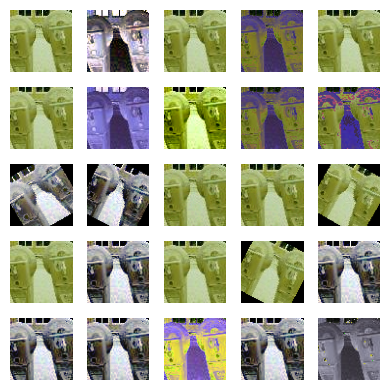

In [1]:
# Run to see data augmentation in action
from pathlib import Path
from tinyimagenet import TinyImageNet

import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

test = TinyImageNet(
    Path("~/.torchvision/tinyimagenet/"),
    split="val",
    imagenet_idx=False,
    transform=transforms.RandomHorizontalFlip(p=0),
)

policy = transforms.AutoAugmentPolicy.IMAGENET
augmenter = transforms.AutoAugment(policy)
transform = transforms.Compose(
    [
        augmenter,
    ]
)

newset = []
index = np.random.randint(0, len(test))

newset.append(test[index][0])

for i in range(24):
    newset.append(transform(test[index][0]))

fig, axes = plt.subplots(5, 5, figsize=(4, 4))

for i, ax in enumerate(axes.flat):
    ax.imshow(newset[i])
    ax.axis("off")

plt.tight_layout()
plt.show()

<center>
Best results out of 5 </br>

| Train Set    | Data Augmentation | Test Loss | Accuracy | F-Measure | Recall | Precision | Training Time  |
| ------------ | ----------------- | --------- | -------- | --------- | ------ | --------- | -------------- |
| 4500 images  | Not Applied       | 1.192     | 0.622    | 0.628     | 0.622  | 0.633     | 35.605 seconds |
| 27000 images | Applied           | 1.112     | 0.660    | 0.663     | 0.660  | 0.666     | 1.500 minutes  |

Table 1 </br>
NP-ResNet18, batch size 32, learning rate 0.001, momentum 0.9, dropout 0, weight decay 0.0 </br>
Tested on 10 classes

Data augmentation helps to improve model performances and generalization. Obviously it will be used in accord with other parameters and computer memory.

</center>


### Classes for test

The classes randomly selected that we use for test are:


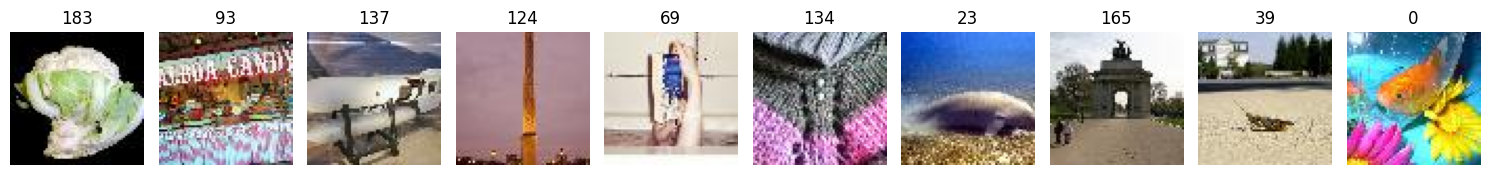

In [2]:
# Run to see the 10 test classes
classes = [183, 93, 137, 124, 69, 134, 23, 165, 39, 0]
newset = []
plus = np.random.randint(0, 50)
for i in classes:
    newset.append(test[i * 50 + plus][0])

for i in range(24):
    newset.append(transform(test[0][0]))

fig, axes = plt.subplots(1, 10, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    ax.imshow(newset[i])
    ax.axis("off")
    ax.set_title(classes[i])

plt.tight_layout()
plt.show()

## **Architecture of Residual Network**

### Resnet block

For the studies we choose resNet18, for its simplicity and shorter training time compared to other residual networks, and resNet50 to observe the difference with deeper networks.

The model is load from Pytorch Hub, it is a pre-trained model repository designed to facilitate research reproducibility. Is possible load pre-trained or not pre-trained model.

The possible block of resNet18 and resNet50 are BasicBlock or Bottleneck:

<center>
<table>
<tr>
    <th>BasicBlock</th>
    <th>Bottleneck</th>
</tr>
<tr>
    <td style="vertical-align: top;">
<pre>

    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)

    if self.downsample is not None:
        identity = self.downsample(x)

    out += identity
    out = self.relu(out)

    return out

</pre>
    </td>
    <td style="vertical-align: top;">
<pre>

    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu(out)

    out = self.conv3(out)
    out = self.bn3(out)

    if self.downsample is not None:
        identity = self.downsample(x)

    out += identity
    out = self.relu(out)

    return out

</pre>
    </td>
</tr>
</table>

Table 2</br>

</center>


### Dropout

Dropout is a regularization technique used in neural networks to prevent overfitting. It works by randomly deactivating (setting to zero) a fraction of neurons during training, which forces the network to learn redundant representations and prevents it from relying too much on specific neurons. This encourages the network to generalize better to unseen data.
Dropout is applied independently to each neuron, so different neurons are dropped out at each iteration.

The basic idea of dropout on residual block is that too dropout can block the learning of important features because the dropout of residual block is less that dropout on fc layers.

In this study we analyze the result of different dropout position in the residual block and in the head of resNet (Different network configuration available to [link](../notes/network.ipynb)).

The common use say to apply dropout after each ReLU. The difference of apply dropout before or after ReLU are insignificant. Dropout and ReLU are a permutable oprerations because [1]:

<center>ReLU(Dropout(x)) = Dropout(ReLU(x)) </center>

<center>
</br>
Best results out of 5 </br>

| Experiment          | Early Stop Epoch | Test Loss | Accuracy | F-Measure | Recall | Precision | Training Time (minutes) |
| ------------------- | ---------------- | --------- | -------- | --------- | ------ | --------- | ----------------------- |
| Dropout before ReLU | 10               | 0.851     | 0.738    | 0.737     | 0.738  | 0.737     | 4.954                   |
| Dropout after ReLU  | 11               | 0.796     | 0.754    | 0.752     | 0.754  | 0.751     | 5.461                   |

Table 3 </br>
NP-ResNet18, batch size 16, learning rate 0.001, momentum 0.9, dropout\_ rb 0.1, dropout_fc 0.0, weight decay 0.0 </br>
Tested on 10 classes (27000 samples with data augmentation)

</center>

This solution work good, but the control on dropout rate is small, especially if we want compare different network. The reason is that this solution apply dropout after or before each ReLU. Therefore if we consider basic block we have applied dropout to 2 ReLU layers, but if we consider bottleneck we have applied dropout to 3 ReLU layers (see table 2).


For this reasons we apply dropout, for each residual block, after the last ReLU before the identity[1]:

<center>
Best results out of 5 </br>

| Experiment                          | Early Stop Epoch | Test Loss | Accuracy | F-Measure | Recall | Precision | Training Time (minutes) |
| ----------------------------------- | ---------------- | --------- | -------- | --------- | ------ | --------- | ----------------------- |
| One dropout for each residual block | 9                | 0.849     | 0.748    | 0.749     | 0.748  | 0.750     | 3.721                   |

Table 4 </br>
NP-ResNet18, batch size 16, learning rate 0.001, momentum 0.9, dropout_rb 0.4, dropout_fc 0.0, weight decay 0.0 </br>
Tested on 10 classes (27000 samples with data augmentation) </br>
</br>
</br>

Average on 5 results </br>
| Experiment | Epochs | Test Loss | Accuracy | F-Measure | Recall | Precision | Training Time (minutes) |
|------------|----------------|-------------------|------------------|-------------------|----------------|-------------------|--------------------------------|
| One dropout for each residual block | 10 | 0.861 | 0.730 | 0.730 | 0.730 | 0.731 | 4.3018 |
| Dropout after ReLU | 10.4 | 0.852 | 0.727 | 0.726 | 0.727 | 0.726 | 4.9976 |

Table 5 </br>
</br>

<div style="display: flex; justify-content: space-around; align-items: center;">
    <figure>
        <img src="../notes/images/one-dropout-for-each-residual-block.jpg" alt="One dropout for each residual block" style="width: 400px;"/>
        <figcaption>Fig.2 - One dropout for each residual block</figcaption>
    </figure>
    <figure>
        <img src="../notes/images/dropout-after-each-relu.jpg" alt="Dropout after each ReLU" style="width: 400px;"/>
        <figcaption>Fig.3 - Dropout after each ReLU</figcaption>
    </figure>
</div>
</center>


In the same way we check the best position for dropout in the head. ResNet head is a simple sequence of AdaptiveAvgPool and linear layer that have as input the output of AdaptiveAvgPool and as output the number of classes that we want to classify.

Because the two possible position of dropout layer are before or after the AdaptiveAvgPool[1].

<center>
Best results out of 5 </br>

| Experiment                     | Early Stop Epoch | Test Loss | Accuracy | F-Measure | Recall | Precision | Training Time (minutes) |
| ------------------------------ | ---------------- | --------- | -------- | --------- | ------ | --------- | ----------------------- |
| Dropout before AdaptiveAvgPool | 17               | 0.751     | 0.762    | 0.762     | 0.762  | 0.761     | 7.212                   |
| Dropout after AdaptiveAvgPool  | 20               | 0.725     | 0.758    | 0.753     | 0.758  | 0.749     | 9.085                   |

Table 6 </br>
NP-ResNet18, batch size 16, learning rate 0.001, momentum 0.9, dropout\_ rb 0.5, dropout_fc 0.5, weight decay 0.0 </br>
Tested on 10 classes (27000 samples with data augmentation) </br>

</center>


## **Pretrained or not-pretrained model**

Now we test the difference between pretrained and not-pretrained model. Not-pretrained model has a weight initialization visible to [link](../notes/network.ipynb).

<center>

| Experiment                                          | Early stop at epoch | Test loss | Accuracy | F-Measure | Recall | Precision | Training time (minutes) |
| --------------------------------------------------- | ------------------- | --------- | -------- | --------- | ------ | --------- | ----------------------- |
| Pretrained ResNet18 with imagenet1k_v1              | 13                  | 0.558     | 0.848    | 0.849     | 0.848  | 0.850     | 5.784                   |
| Not-pretrained ResNet18 with weights initialization | 17                  | 0.751     | 0.762    | 0.762     | 0.762  | 0.761     | 7.212                   |

Table 7 </br>
P-resNet18, batch size 16, learning rate 0.001, momentum 0.9, dropout\_ rb 0.5, dropout_fc 0.5, weight decay 0.0 </br>
Tested on 10 classes (27000 samples with data augmentation) </br>

</center>

We can conclude that pretrained model is better than not-pretrained model, therefore we use:

- Pretrained model with fine-tuning for the study on the 200 classes,
- Train the network from scratch for the second studies proposed by professor.


## **Comparison between resNet18 and resNet50**

In the fig.1 we can see that the big difference in different type of resNet is the depth of network. A residual network with more layer can learn more feature, with more robustness.

<center>

| Model       | Early stop at epoch | Test loss | Accuracy | F-Measure | Recall | Precision | Training time (mins) |
| ----------- | ------------------- | --------- | -------- | --------- | ------ | --------- | -------------------- |
| NP-ResNet18 | 16                  | 0.807     | 0.744    | 0.743     | 0.744  | 0.742     | 7.356                |
| NP-ResNet50 | 41                  | 0.965     | 0.700    | 0.700     | 0.700  | 0.701     | 51.126               |

Table 8</br>
Batch size 16, learning rate 0.001, momentum 0.9, dropout\_ rb 0.5, dropout_fc 0.5, weight decay 0.0 </br>
Tested on 10 classes (27000 samples with data augmentation) </br>

</center>

We can see that resNet18 in less epochs and less time obtain better results than resNet50. This is probably a consequence of more depth (and parameters) of resNet50 that need more samples to learn classes features.


<center>

| Model       | Samples | Early stop at epoch | Test loss | Accuracy | F-Measure | Recall | Precision | Training time  |
| ----------- | ------- | ------------------- | --------- | -------- | --------- | ------ | --------- | -------------- |
| NP-ResNet18 | 81000   | 8                   | 0.785     | 0.750    | 0.753     | 0.750  | 0.755     | 9.967 minutes  |
| NP-ResNet50 | 81000   | 17                  | 0.854     | 0.728    | 0.727     | 0.728  | 0.725     | 1.029 hours    |
| NP-ResNet18 | 135000  | 5                   | 0.787     | 0.746    | 0.743     | 0.746  | 0.741     | 10.095 minutes |
| NP-ResNet50 | 135000  | 11                  | 0.788     | 0.740    | 0.739     | 0.740  | 0.738     | 1.068 hours    |

Table 9 </br>
Batch size 16, learning rate 0.001, momentum 0.9, dropout\_ rb 0.5, dropout_fc 0.5, weight decay 0.0 </br>
Tested on 10 classes </br>

</center>

We can see that with more sample we can improve the metrics of resNet50, but takes more time for training.
The difference between resNet18 and resNet50 is that a network with more layers has more capacity to extract feature than network with less layers but with image 64x64 the feature extraction is probably very difficult.
A network with more layers has more capacity to extract feature than network with less layers because have more parameters, but the capacity of support model with more layer is related with device memory and computational power.


## **Learning rate and batch size**

Possible technique to perform better your neural network are gridSearch and bayesSearch, but this approach needs more time, especially if we have a lot of parameters to set.

- Learning rate: in machine learning is like the pace at which a model learns. It determines how big or small the steps are during training. Too high, and it might overshoot; too low, and it might be too slow.

- Batch size: when training a neural network, data is divided into smaller batches, and the model’s parameters are updated based on the average gradient computed from each batch. The choice of batch size impacts training efficiency, memory usage, and convergence behavior. Larger batch sizes can speed up training but require more memory, while smaller batch sizes may lead to more frequent parameter updates but slower convergence.

This parameters affect the training time and performace.

We need to decrese the training time without influence the performance of the network.


### Step Learning Rate

A power technique to better perform the training is dynamic learning rate, we start with learning rate too high and with some procedure we update it during the training.

<center>
Best results out of 3 </br>

Update step 3 </br>

| Gamma | Early stop at epoch | Test loss | Accuracy | F-Measure | Recall | Precision | Training time (minutes) |
| ----- | ------------------- | --------- | -------- | --------- | ------ | --------- | ----------------------- |
| 0.3   | 10                  | 0.768     | 0.736    | 0.737     | 0.736  | 0.737     | 4.344                   |
| 0.2   | 25                  | 0.768     | 0.732    | 0.730     | 0.732  | 0.728     | 10.36                   |
| 0.1   | 20                  | 0.806     | 0.704    | 0.695     | 0.704  | 0.687     | 8.625                   |

Update step 5 </br>

| Gamma | Early stop at epoch | Test loss                                  | Accuracy                                   | F-Measure | Recall | Precision | Training time (minutes)                    |
| ----- | ------------------- | ------------------------------------------ | ------------------------------------------ | --------- | ------ | --------- | ------------------------------------------ |
| 0.3   | 7                   | 0.751                                      | 0.750                                      | 0.748     | 0.750  | 0.746     | 3.245                                      |
| 0.2   | 8                   | <span style="color:green">**0.711**</span> | <span style="color:green">**0.774**</span> | 0.774     | 0.774  | 0.774     | 3.290                                      |
| 0.1   | 6                   | <span style="color:green">**0.710**</span> | 0.750                                      | 0.747     | 0.750  | 0.745     | <span style="color:green">**2.669**</span> |

Update step 7 </br>

| Gamma | Early stop at epoch | Test loss | Accuracy | F-Measure | Recall | Precision | Training time (minutes) |
| ----- | ------------------- | --------- | -------- | --------- | ------ | --------- | ----------------------- |
| 0.3   | 8                   | 0.761     | 0.744    | 0.743     | 0.744  | 0.742     | 3.458                   |
| 0.2   | 8                   | 0.794     | 0.762    | 0.762     | 0.762  | 0.763     | 3.480                   |
| 0.1   | 8                   | 0.749     | 0.750    | 0.751     | 0.750  | 0.751     | 3.458                   |

Table 10</br>
NP-ResNet18, batch size 16, start LR 0.01, momentum 0.9, dropout\_ rb 0.5, dropout_fc 0.5, weight decay 0.0</br>
Tested on 10 classes (27000 samples with data augmentation)</br>

</center>

</br>
</br>
We can hypothesize that too low step size needs to high gamma and too high step size needs too low gamma.


### Step Batch Size

Another technique is increase the batch size during the training. This approach allows you to have similar results to decrease learning rate (slightly worse) but with the increment of batch size the parameters updated during the training are less and in the same way the training time is decreases[2].

<center>
Best results out of 3</br>

Update step 3 </br>

| Gamma | Epoch | Test Loss | Accuracy | F-Measure | Recall | Precision | Time (minutes)                             |
| ----- | ----- | --------- | -------- | --------- | ------ | --------- | ------------------------------------------ |
| 4     | 7     | 0.752     | 0.746    | 0.744     | 0.746  | 0.742     | <span style="color:green">**2.082**</span> |
| 2     | 7     | 0.796     | 0.756    | 0.757     | 0.756  | 0.757     | 3.100                                      |

Update step 5 </br>

| Gamma | Epoch | Test Loss | Accuracy                                   | F-Measure | Recall | Precision | Time (minutes) |
| ----- | ----- | --------- | ------------------------------------------ | --------- | ------ | --------- | -------------- |
| 4     | 7     | 0.765     | 0.732                                      | 0.730     | 0.732  | 0.727     | 2.490          |
| 2     | 7     | 0.749     | <span style="color:green">**0.764**</span> | 0.765     | 0.764  | 0.767     | 2.943          |

Update step 7 </br>

| Gamma | Epoch | Test Loss                                  | Accuracy | F-Measure | Recall | Precision | Time (minutes) |
| ----- | ----- | ------------------------------------------ | -------- | --------- | ------ | --------- | -------------- |
| 4     | 8     | 0.757                                      | 0.744    | 0.743     | 0.744  | 0.743     | 3.079          |
| 2     | 8     | <span style="color:green">**0.719**</span> | 0.756    | 0.755     | 0.756  | 0.755     | 3.269          |

Table 11 </br>
NP-ResNet18, start BS 16, learning rate 0.01, momentum 0.9, dropout\_ rb 0.5, dropout_fc 0.5, weight decay 0.0 </br>
Tested on 10 classes (27000 samples with data augmentation) </br>

</center>


### Hybrid solution

Another solution is use an hybrid approach [2]. It is possible the best solution because merge the too high performance obtained with stepLR and the too low time needed with stepBS.
</br>
</br>

<center>
Average on 3 results </br>

| Method        | Epochs                                    | Test Loss                                  | Accuracy                                   | F-Measure | Recall | Precision | Time (minutes)                             |
| ------------- | ----------------------------------------- | ------------------------------------------ | ------------------------------------------ | --------- | ------ | --------- | ------------------------------------------ |
| StepLR        | 8                                         | <span style="color:green">**0.742**</span> | <span style="color:green">**0.761**</span> | 0.761     | 0.761  | 0.761     | 3.429                                      |
| StepBS        | 7                                         | 0.754                                      | 0.748                                      | 0.748     | 0.748  | 0.748     | 3.051                                      |
| StepLR+StepBS | <span style="color:green">**6.67**</span> | <span style="color:green">**0.742**</span> | 0.749                                      | 0.747     | 0.749  | 0.746     | <span style="color:green">**2.874**</span> |

Table 12</br>
NP-ResNet18, start BS 16, start LR 0.01, momentum 0.9, dropout\_ rb 0.5, dropout_fc 0.5, weight decay 0.0, gamma_LR 0.2, gamma_BS 2, step 5</br>
Tested on 10 classes (27000 samples with data augmentation)</br>
</br>

</center>

Is import to remember that the batch size must be taken in accordance with the device's memory. For this reason we check that the range of train batch size is between [4, 512].

In the same way too low learning rate don't have effect on training therefore we set the min learning rate equal to 0.000001.


## **Weight Decay**

Weight decay, also known as L2 regularization or weight regularization, is a technique commonly used in machine learning and neural network training to prevent overfitting.
In the context of neural networks, weight decay works by adding a penalty term to the loss function during training. This penalty is proportional to the squared magnitude of the weights in the network. The effect is that during training, the network not only tries to minimize the error on the training data but also tries to keep the weights as small as possible.

<center>
Average on 3 results </br>

| Weight decay | Epochs | Test Loss | Accuracy | F-Measure | Recall | Precision | Time (minutes) |
| ------------ | ------ | --------- | -------- | --------- | ------ | --------- | -------------- |
| 0.0          | 13.67  | 0.766     | 0.741    | 0.738     | 0.741  | 0.735     | 5.4417         |
| 0.001        | 10.33  | 0.788     | 0.746    | 0.747     | 0.746  | 0.748     | 4.617          |
| 0.01         | 13     | 0.702     | 0.771    | 0.771     | 0.771  | 0.771     | 7.684          |

Table 13</br>
NP-ResNet18, start BS 16, start LR 0.01, momentum 0.9, dropout\_ rb 0.5, dropout_fc 0.7,
gamma_LR 0.2, gamma_BS 2, step 5</br>
Tested on 10 classes (27000 samples with data augmentation)</br>

</center>


## **Confusion matrix**

The classes that we use to study the resNet performace are randomly selected. With image with high resolution, well defined and focused on subjects this is probably not a problem, but in context of Tiny ImageNet where we are images subsampled from ImagNet with size of 64x64 the classes selection is probably a big problem because the network could confuse the features of different subjects.

<center>

To test this hypothesis we decided to print the confusion matrix:

<figure>
    <img src="../notes/images/conf_matrix_weight_decay.jpg" alt="Dropout after each ReLU" style="width: 600px;"/>
    <figcaption>Fig. 4</figcaption>
</figure>

</center>

We can see that the network learn better the feature of classes 93, 124, 23, 165, 39 and 0.
Less better class 183 and with high difficult 137, 69, 134.


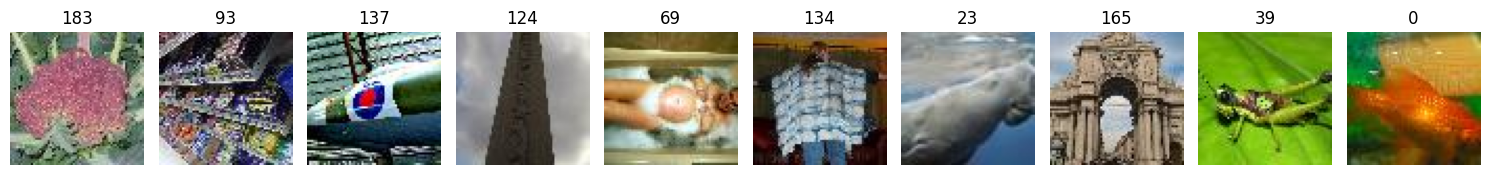

In [4]:
# Run to see the 10 test classes
classes = [183, 93, 137, 124, 69, 134, 23, 165, 39, 0]
newset = []
plus = np.random.randint(0, 50)
for i in classes:
    newset.append(test[i * 50 + plus][0])

for i in range(24):
    newset.append(transform(test[0][0]))

fig, axes = plt.subplots(1, 10, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    ax.imshow(newset[i])
    ax.axis("off")
    ax.set_title(classes[i])

plt.tight_layout()
plt.show()

<center>

The same results are visible when we try to train the network on all classes: </br>

| Early Stop at Epoch | Test Loss | Accuracy | F-Measure | Recall | Precision | Time (minutes) |
| ------------------- | --------- | -------- | --------- | ------ | --------- | -------------- |
| 11                  | 1.945     | 0.527    | 0.528     | 0.527  | 0.528     | 40.115         |

Table 14</br>
P-ResNet18, start BS 64, start LR 0.001, momentum 0.9, dropout\_ rb 0.3, dropout_fc 0.5, weight decay 0.0005,
gamma_LR 0.2, gamma_BS 2, step 5</br>
200 classes (540000 samples with data augmentation)</br>
</br>

<figure>
    <img src="../notes/images/conf_matrix_200_classes_weight_decay.png" alt="Dropout after each ReLU" style="width: 600px;"/>
    <figcaption>Fig. 6</figcaption>
</figure>

</center>

Until now we use data augmentation, dropout, weights decay, early stop, stepper for learning rate and batch size to improve the network performance.
The dataset was divided into 450 images for train set, 50 images for validation set and 50 images for test set for each class.

The result was that the network has difficult to classify some classes of images probably because:

- There are too low samples for each class,
- The images resolution is low,
- There are subjects that has features really similar.

For this reason we need to help network to learn the images where it has more difficult.


## **More original images for training**

Because we have 550 original images for each class we decide to remove the test set and use 500 images for train and 50 for validation.

<center>
Best results out of 3</br>
</br>

| Configuration | Early Stop at Epoch | Test Loss | Accuracy | F-Measure | Recall | Precision | Time (minutes) |
| ------------- | ------------------- | --------- | -------- | --------- | ------ | --------- | -------------- |
| 450-50-50     | 13                  | 0.674     | 0.776    | 0.777     | 0.776  | 0.778     | 8.273          |
| 500-50        | 15                  | 0.669     | 0.786    | 0.785     | 0.786  | 0.785     | 6.129          |

Table 15</br>
NP-ResNet18, start BS 16, start LR 0.01, momentum 0.9, dropout\_ rb 0.5, dropout_fc 0.7, weight decay 0.01,
gamma_LR 0.2, gamma_BS 2, step 5 </br>
Tested on 10 classes </br>

</center>

This solution is not a good choice for a production model, but in the research context it is acceptable.
